In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from textacy.preprocessing.resources import (RE_EMAIL , RE_URL , RE_NUMBER ,
                                              RE_NUMBER , RE_EMOJI , RE_SHORT_URL , RE_PHONE_NUMBER
                                            )
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score , classification_report , ConfusionMatrixDisplay , confusion_matrix, f1_score
from transformers import AutoTokenizer , AutoModelForSequenceClassification  , AutoModel , Trainer , TrainingArguments
from datasets import Dataset , DatasetDict 
import torch

In [5]:
#load datasets
df = pd.read_csv("all-data.csv", encoding_errors='ignore' , header=None )
df.columns = ['Label' , 'text']
df.head()

,Label,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4846 non-null   object
 1   text    4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [9]:
df.duplicated().sum()


6

In [10]:
#remove duplicated 
df.drop_duplicates(inplace=True)
assert df.duplicated().sum() == 0 , 'there are dubplicared values'

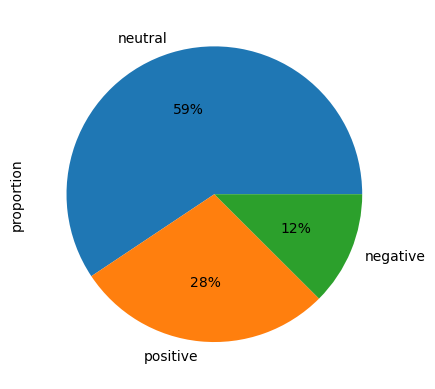

In [14]:
#check label values percentage 
df['Label'].value_counts(normalize=True).plot(kind="pie", autopct='%1.0f%%')
plt.show()

In [20]:
#clean data for to only get relevent infprmation that be used in senmatic meaning


In [21]:
def clean(text):
    text = RE_EMAIL.sub('' ,text)
    
    text = RE_EMOJI.sub('' , text)
    
    text = RE_NUMBER.sub('' , text)
    
    text = RE_PHONE_NUMBER.sub('' , text)
    
    text = RE_URL.sub('' , text)
    
    text = RE_SHORT_URL.sub('' , text)
    
    return text

In [30]:
df['text'].apply(lambda x : len(x)<10).sum()

1

In [22]:
df['text'] = df['text'].apply(clean)

In [23]:
df['text'].head()

0    According to Gran , the company has no plans t...
1    Technopolis plans to develop in stages an area...
2    The international electronic industry company ...
3    With the new production plant the company woul...
4    According to the company 's updated strategy f...
Name: text, dtype: object

In [24]:
#first split data 

X_train, X_valid, y_train, y_valid = train_test_split(df['text'] , df['Label'] , 
                                                      test_size=0.2 , shuffle=True , random_state=42 , 
                                                      stratify=df['Label'])

In [25]:
X_train.shape , X_valid.shape

((3872,), (968,))

In [26]:
X_valid , X_test , y_valid , y_test = train_test_split(X_valid, y_valid , 
                                                       test_size=0.5 , 
                                                       stratify=y_valid)

In [27]:
X_train.shape , X_valid.shape ,X_test.shape

((3872,), (484,), (484,))

In [42]:
#bulld a simple pipeline 
vectorizer = TfidfVectorizer(ngram_range=(1, 2) , min_df=20 , max_df=0.7 ,) 

In [32]:
model = Pipeline(steps=[vectorizer , LogisticRegression()])

In [34]:
labels = ['neutral', 'positive', 'negative']

In [57]:
def plot_confusion_metricss(y_pred , y_true , ax , split):
    cm = confusion_matrix(y_true , y_pred , normalize='true')
    disp = ConfusionMatrixDisplay(cm , display_labels=labels)
    disp.plot(cmap='Blues' , values_format='.2f' , ax = ax , colorbar=False)
    ax.set_title(f"Normalized Confusion Metrics for {split}")

In [62]:
def get_metrics_repors(model):
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    
    print('According to train data ......')
    
    print(classification_report(y_train , y_train_pred , labels=labels))
    
    print(f"Train Acuuracy {accuracy_score(y_train , y_train_pred)*100:0.2f}%")
    
    print("According to validation data .....")
    
    print(classification_report(y_valid , y_valid_pred , labels=labels))
    
    print(f"Valid Acuuracy {accuracy_score(y_valid, y_valid_pred)*100:0.2f}%")
    
    fig , (ax1 , ax2) = plt.subplots(1 , 2 , figsize = (12, 12) , sharey=True)
    
    plot_confusion_metricss(y_train_pred , y_train , ax1 , split='Train')
    
    plot_confusion_metricss(y_valid_pred , y_valid , ax2 , split='Valid')
    
    plt.show()
    
    

In [59]:

lr_model = Pipeline(steps=[("vectorizer", vectorizer) , ('model' , LogisticRegression())])

In [60]:
lr_model.fit(X_train , y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.7, min_df=20, ngram_range=(1, 2))),
                ('model', LogisticRegression())])

According to train data ......
              precision    recall  f1-score   support

     neutral       0.80      0.96      0.87      2298
    positive       0.83      0.64      0.73      1091
    negative       0.88      0.54      0.67       483

    accuracy                           0.82      3872
   macro avg       0.84      0.71      0.76      3872
weighted avg       0.82      0.82      0.81      3872

Train Acuuracy 81.51%
According to validation data .....
              precision    recall  f1-score   support

     neutral       0.74      0.90      0.81       287
    positive       0.68      0.54      0.60       136
    negative       0.79      0.36      0.49        61

    accuracy                           0.73       484
   macro avg       0.73      0.60      0.64       484
weighted avg       0.73      0.73      0.71       484

Valid Acuuracy 72.93%


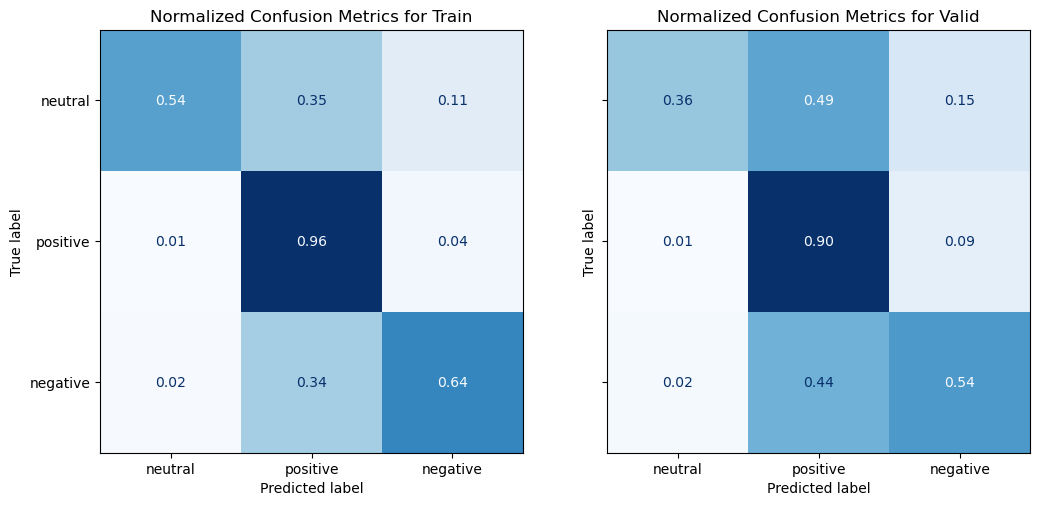

In [63]:
get_metrics_repors(lr_model)

In [64]:
random_forest_model = Pipeline(steps=[("vectorizer", vectorizer) , ('model' , RandomForestClassifier())])

In [65]:
random_forest_model.fit(X_train , y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.7, min_df=20, ngram_range=(1, 2))),
                ('model', RandomForestClassifier())])

According to train data ......
              precision    recall  f1-score   support

     neutral       1.00      1.00      1.00      2298
    positive       1.00      1.00      1.00      1091
    negative       0.99      1.00      0.99       483

    accuracy                           1.00      3872
   macro avg       1.00      1.00      1.00      3872
weighted avg       1.00      1.00      1.00      3872

Train Acuuracy 99.77%
According to validation data .....
              precision    recall  f1-score   support

     neutral       0.73      0.94      0.82       287
    positive       0.76      0.46      0.58       136
    negative       0.80      0.46      0.58        61

    accuracy                           0.74       484
   macro avg       0.76      0.62      0.66       484
weighted avg       0.75      0.74      0.72       484

Valid Acuuracy 74.38%


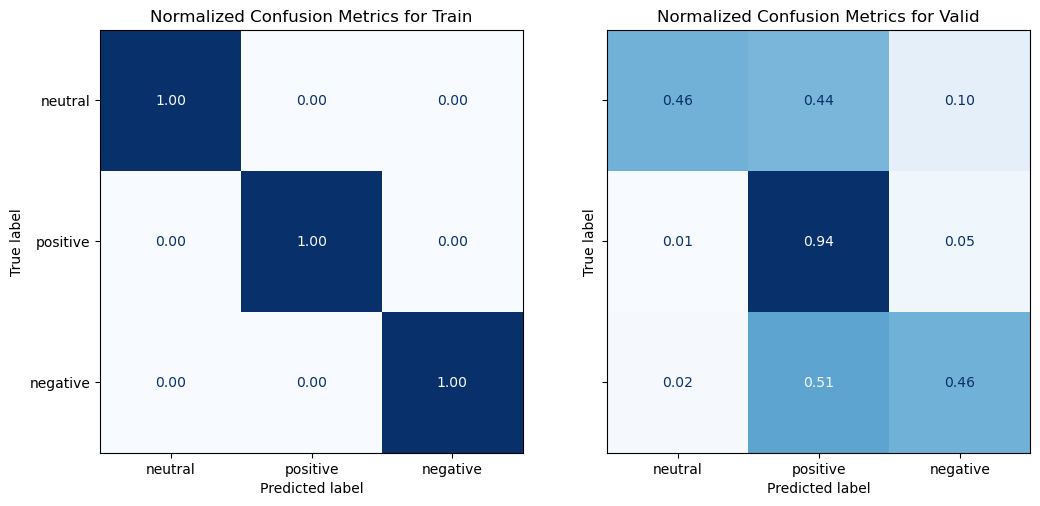

In [66]:
get_metrics_repors(random_forest_model)

In [74]:
#we have overfitting 
random_forest_model = Pipeline(steps=[("vectorizer", vectorizer) , ('model' , RandomForestClassifier(
    n_estimators=90 , min_samples_leaf=2 
))])

In [75]:
random_forest_model.fit(X_train , y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.7, min_df=20, ngram_range=(1, 2))),
                ('model',
                 RandomForestClassifier(min_samples_leaf=2, n_estimators=90))])

According to train data ......
              precision    recall  f1-score   support

     neutral       0.87      0.99      0.93      2298
    positive       0.96      0.80      0.88      1091
    negative       0.98      0.70      0.82       483

    accuracy                           0.90      3872
   macro avg       0.94      0.83      0.87      3872
weighted avg       0.91      0.90      0.90      3872

Train Acuuracy 90.19%
According to validation data .....
              precision    recall  f1-score   support

     neutral       0.73      0.94      0.82       287
    positive       0.77      0.46      0.58       136
    negative       0.77      0.38      0.51        61

    accuracy                           0.74       484
   macro avg       0.75      0.59      0.64       484
weighted avg       0.74      0.74      0.71       484

Valid Acuuracy 73.76%


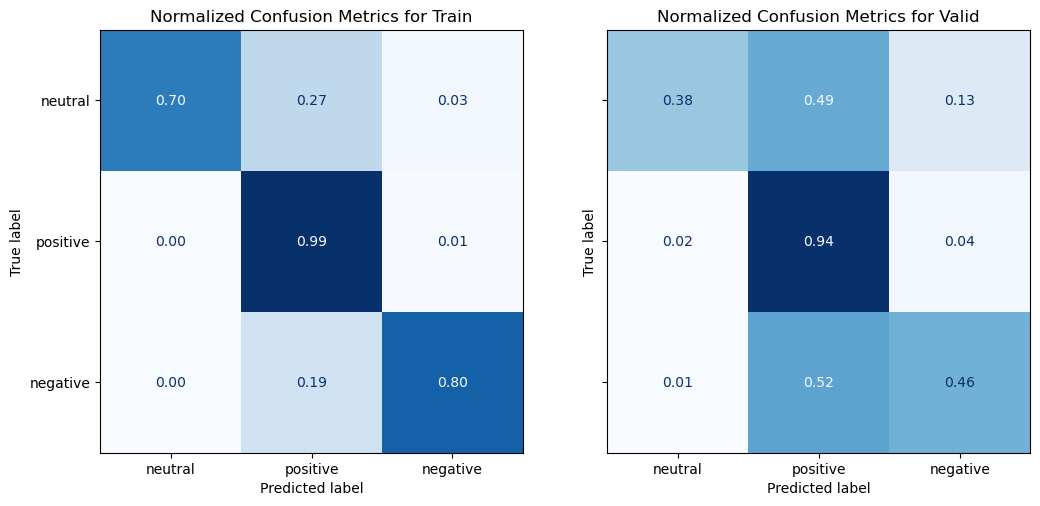

In [76]:
get_metrics_repors(random_forest_model)

In [96]:
#use bert to make encoding
model_checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModel.from_pretrained(model_checkpoint  , num_labels = 3)

C:\Users\oscar\AppData\Roaming\Python\Python310\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [109]:
def get_embedding(texts):
    outputs  = []
    
    for text in texts:
        inputs = tokenizer(text , return_tensors='pt')
        inputs ={k:v.to("cpu") for k , v in inputs.items()}
        
        with torch.no_grad():
            output = model(**inputs).last_hidden_state.cpu().numpy().mean(axis=1)
            
            outputs.append(output)
        
    return np.array(outputs)
        
    

In [110]:
res = get_embedding(X_valid.values)

In [112]:
res.squeeze(1).shape

(484, 768)

In [135]:
class BERTEncoding(BaseEstimator):
    def __init__(self  , **kwargs):
      super().__init__(**kwargs)
      return None
        
    def fit(self , X , y=None):
        self.X = X 
        self.y = y
        return self
    
    def transform(self , X):
        outputs = get_embedding(X.values)
        return outputs.squeeze(1)

In [136]:
bert_lr = Pipeline(steps=[('bert' , BERTEncoding()) , ('classifer' , LogisticRegression())])

In [137]:
bert_lr.fit(X_train , y_train)

c:\Users\oscar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('bert', BERTEncoding()), ('classifer', LogisticRegression())])

According to train data ......
              precision    recall  f1-score   support

     neutral       0.90      0.94      0.92      2298
    positive       0.84      0.77      0.80      1091
    negative       0.85      0.83      0.84       483

    accuracy                           0.88      3872
   macro avg       0.86      0.84      0.85      3872
weighted avg       0.87      0.88      0.87      3872

Train Acuuracy 87.58%
According to validation data .....
              precision    recall  f1-score   support

     neutral       0.80      0.86      0.83       287
    positive       0.68      0.56      0.61       136
    negative       0.66      0.67      0.67        61

    accuracy                           0.75       484
   macro avg       0.71      0.70      0.70       484
weighted avg       0.75      0.75      0.75       484

Valid Acuuracy 75.41%


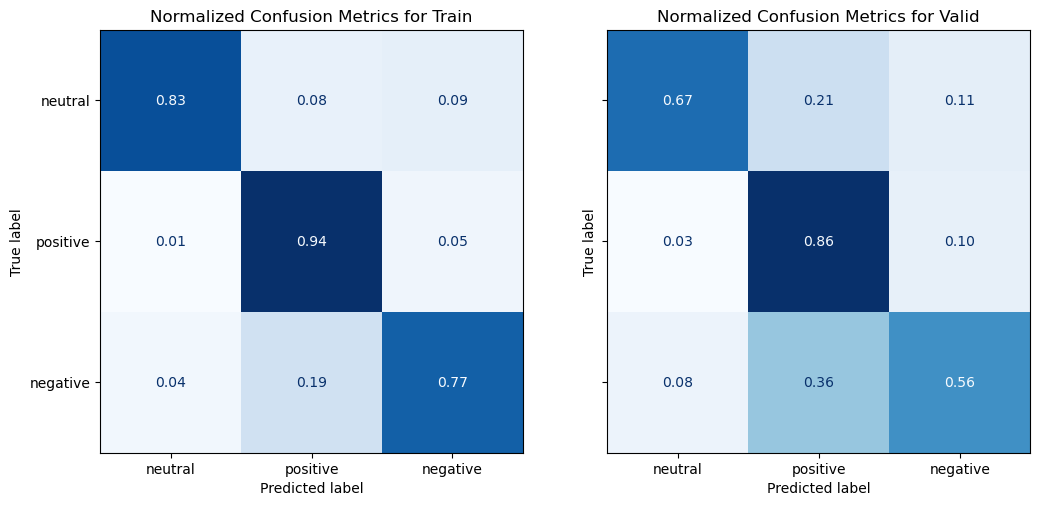

In [138]:
get_metrics_repors(bert_lr)

In [139]:
bert_rf = Pipeline(steps=[('bert' , BERTEncoding()) , ('classifer' , RandomForestClassifier())])
bert_rf.fit(X_train  , y_train)

Pipeline(steps=[('bert', BERTEncoding()),
                ('classifer', RandomForestClassifier())])

According to train data ......
              precision    recall  f1-score   support

     neutral       1.00      1.00      1.00      2298
    positive       1.00      1.00      1.00      1091
    negative       1.00      1.00      1.00       483

    accuracy                           1.00      3872
   macro avg       1.00      1.00      1.00      3872
weighted avg       1.00      1.00      1.00      3872

Train Acuuracy 99.92%
According to validation data .....
              precision    recall  f1-score   support

     neutral       0.71      0.97      0.82       287
    positive       0.65      0.36      0.46       136
    negative       0.70      0.23      0.35        61

    accuracy                           0.70       484
   macro avg       0.69      0.52      0.54       484
weighted avg       0.70      0.70      0.66       484

Valid Acuuracy 70.45%


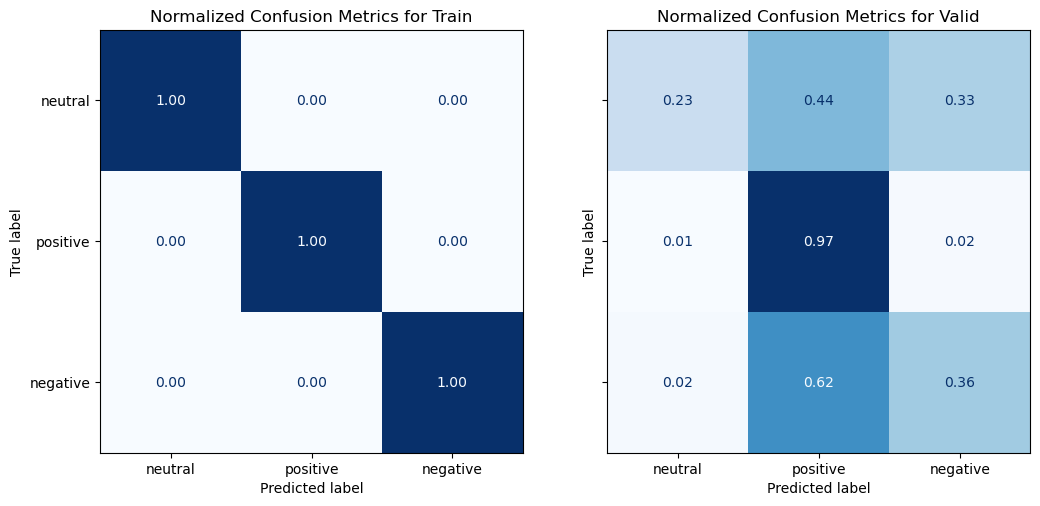

In [140]:
get_metrics_repors(bert_rf)

In [145]:
final_res = pd.DataFrame(
    {'accuracy':[accuracy_score(y_test , lr_model.predict(X_test)),
                 accuracy_score(y_test , random_forest_model.predict(X_test)),
                 accuracy_score(y_test , bert_lr.predict(X_test)),
                 accuracy_score(y_test , bert_rf.predict(X_test))]  ,
     'f1':[f1_score(y_test , lr_model.predict(X_test), average='weighted'),
                 f1_score(y_test , random_forest_model.predict(X_test) , average='weighted'),
                 f1_score(y_test , bert_lr.predict(X_test), average='weighted'),
                 f1_score(y_test , bert_rf.predict(X_test), average='weighted')]} , 
    index=['LR', 'RF' , 'BERT_LR' , 'BERT_RF']
)

In [147]:
final_res.head()

,accuracy,f1
LR,0.741736,0.729002
RF,0.743802,0.724009
BERT_LR,0.768595,0.768036
BERT_RF,0.723140,0.686382


<Axes: >

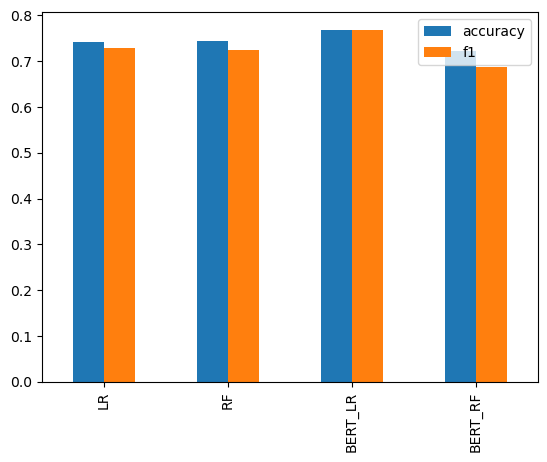

In [148]:
final_res.plot(kind='bar')

In [149]:
#as we see bert with LR is the best

In [150]:
#fine tune BERT Model


In [151]:
#prepera dataset

In [154]:
pd.concat([X_train , y_train], axis=1)

,text,Label
1423,The shares carry a right to dividend and other...,neutral
1685,UPM-Kymmene has generated four consecutive qua...,positive
857,"Known as Post Bank , the concept would see Fid...",positive
4834,Hobby Hall 's sales decrease pct due to imple...,negative
3377,The total restructuring costs are expected to ...,neutral
...,...,...
443,SHARE REPURCHASE .2008 In the Helsinki Stock E...,neutral
659,The diluted loss per share narrowed to EUR fr...,positive
2359,shares can still be subscribed for with Serie...,neutral
4771,UPM stock fell percent to EURO $ in early a...,negative


In [169]:
dataset = DatasetDict({"train":Dataset.from_pandas(pd.concat([X_train , y_train], axis=1)) , 
                       "valid":Dataset.from_pandas(pd.concat([X_valid , y_valid], axis=1)), 
                       "test":Dataset.from_pandas(pd.concat([X_test , y_test], axis=1))})

In [161]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'Label', '__index_level_0__'],
        num_rows: 3872
    })
    valid: Dataset({
        features: ['text', 'Label', '__index_level_0__'],
        num_rows: 484
    })
    test: Dataset({
        features: ['text', 'Label', '__index_level_0__'],
        num_rows: 484
    })
})

In [170]:
prep_dataset = dataset.map(lambda x : tokenizer(x['text'] , padding=True , truncation=True) , remove_columns=['text'], batched=False)
prep_dataset = prep_dataset.rename_columns({"Label":'label'})

Map:   0%|          | 0/3872 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

In [189]:
y_test.unique()

array(['positive', 'neutral', 'negative'], dtype=object)

In [194]:
labels_mapping = {'neutral':0 , 'positive':1 , 'negative':2}
prep_dataset = prep_dataset.map(lambda x : {"label":labels_mapping[x['label']]})


Map:   0%|          | 0/3872 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

In [171]:
prep_dataset

DatasetDict({
    train: Dataset({
        features: ['label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 3872
    })
    valid: Dataset({
        features: ['label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 484
    })
    test: Dataset({
        features: ['label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 484
    })
})

In [172]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint , num_labels = 3)

C:\Users\oscar\AppData\Roaming\Python\Python310\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [173]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels , preds  , average='weighted')
    acc = accuracy_score(labels , preds)
    return {"accuracy":acc , 'f1_score':f1}


In [186]:
trainig_args = TrainingArguments(
    output_dir='./fine-tuned-bert-for-sentiment-analysis-task' , 
    num_train_epochs=2 , 
    learning_rate=2e-5,
    per_device_train_batch_size=32, 
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    disable_tqdm=False , 
    warmup_ratio=0.001 ,
    lr_scheduler_type='linear',
    logging_dir='./res'
)

In [195]:
trainer = Trainer(model=model , args=trainig_args ,
                  compute_metrics=compute_metrics , 
                  train_dataset=prep_dataset['train'] , 
                  eval_dataset=prep_dataset['valid'] , 
                  tokenizer=tokenizer
                  
                  )

In [196]:
trainer.train()

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.49056440591812134, 'eval_accuracy': 0.7913223140495868, 'eval_f1_score': 0.7924978082599216, 'eval_runtime': 46.7444, 'eval_samples_per_second': 10.354, 'eval_steps_per_second': 0.663, 'epoch': 1.0}


  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.46295562386512756, 'eval_accuracy': 0.8016528925619835, 'eval_f1_score': 0.8022191200926144, 'eval_runtime': 39.9815, 'eval_samples_per_second': 12.106, 'eval_steps_per_second': 0.775, 'epoch': 2.0}
{'train_runtime': 2049.9678, 'train_samples_per_second': 3.778, 'train_steps_per_second': 0.118, 'train_loss': 0.5280464739838907, 'epoch': 2.0}


TrainOutput(global_step=242, training_loss=0.5280464739838907, metrics={'train_runtime': 2049.9678, 'train_samples_per_second': 3.778, 'train_steps_per_second': 0.118, 'train_loss': 0.5280464739838907, 'epoch': 2.0})

In [199]:
bert_res = trainer.predict(prep_dataset['test']).metrics

In [200]:
bert_res

{'test_loss': 0.39603734016418457,
 'test_accuracy': 0.8367768595041323,
 'test_f1_score': 0.8382153056051703,
 'test_runtime': 38.363,
 'test_samples_per_second': 12.616,
 'test_steps_per_second': 0.808}

In [201]:
final_res.loc['BERT', :] = {'accuracy':bert_res['test_accuracy'] , 'f1': bert_res['test_f1_score']}

In [202]:
final_res.head()

,accuracy,f1
LR,0.741736,0.729002
RF,0.743802,0.724009
BERT_LR,0.768595,0.768036
BERT_RF,0.723140,0.686382
BERT,0.836777,0.838215


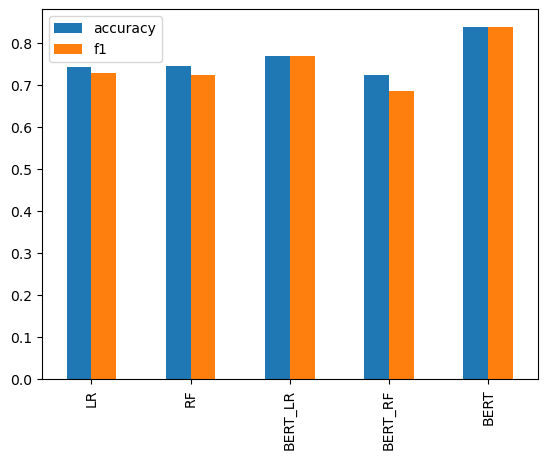

In [203]:
final_res.plot(kind='bar')
plt.show()

In [204]:
#fine-tuneed bert is the best

In [210]:
y_test_pred = trainer.predict(prep_dataset['test']).predictions

  0%|          | 0/31 [00:00<?, ?it/s]

In [216]:
y_test_pred = y_test_pred.argmax(axis=1)

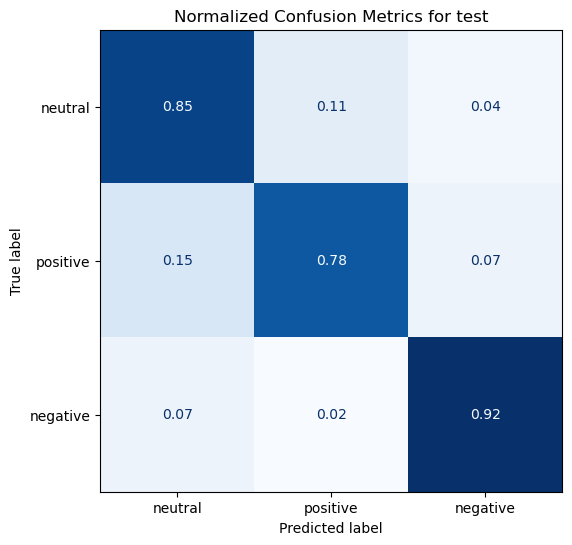

In [217]:
fig , ax = plt.subplots(1,1, figsize=(6,6))
plot_confusion_metricss(y_test_pred , y_test.apply(lambda x  :labels_mapping[x]) , ax , 'test')